## MST Reserving Model v0.1

Date: 12/20/2024<br>
<br>
Test model for testing potential methodology using sample data.  The model is considered ready for testing with MST data now that it can meet the following requirements:
1. Utilize manually input loss development factors
2. Utilize manually input a' priori loss ratios
3. Perform `Chainladder` method using the manual ldfs
4. Perform `BornhuetterFerguson` method using manual ldfs and a' prior loss ratios
5. Perform `CapeCod` method using manual ldfs
6. Perform a Least Squares method
7. Balance to excel model output (MST_reserve_modelv0.1.xlsx)
 

## Importing libraries and data

### Library dependicies
`chainladder` for building chainladder, BF, and GCC models. Also useful for building triangles.<br> 
`pandas` data munipulation<br>
`matplotlib` for plotting (duh) <br>
`sklearn.linear_model.LinearRegression` for the Least Squares method

### Data sources:
1. clrd_lob.csv
    - Sample triangle dataset
2. cdf_constants.csv
    - Manually selected cumulative loss development factors
    - aka ATU factors
3. ELR.xlsx
    - Manually selected expected loss ratios

In [1]:
#import libraries
import chainladder as cl #building reserve model and triangles
import pandas as pd #Dataframe manipulation
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
print("Chainladder version: "+cl.__version__)

Chainladder version: 0.8.22


In [2]:
#Importing data
df_data = pd.read_csv("clrd_lob.csv")
df_cdf = pd.read_csv("cdf_constants.csv")
df_elr = pd.read_excel("ELR.xlsx")

In [3]:
df_data.dtypes

LOB                object
origin             object
valuation          object
development         int64
IncurLoss           int64
CumPaidLoss         int64
BulkLoss            int64
EarnedPremDIR       int64
EarnedPremCeded     int64
EarnedPremNet       int64
dtype: object

In [4]:
df_elr.head()

,LOB,origin,ELR
0,comauto,1988-01-01,0.65
1,comauto,1989-01-01,0.65
2,comauto,1990-01-01,0.65
3,comauto,1991-01-01,0.65
4,comauto,1992-01-01,0.65


In [5]:
df_elr.dtypes

LOB               object
origin    datetime64[ns]
ELR              float64
dtype: object

In [6]:
#Convert columns to pandas datetime
date_columns = ['origin', 'valuation']
df_data[date_columns] = df_data[date_columns].apply(pd.to_datetime)

In [7]:
#merging df_elr with df_data to create UltExpectedDIRLoss
df_data = pd.merge(df_data, df_elr, on=['LOB', 'origin'], how='left')

In [8]:
df_data.head()

,LOB,origin,valuation,development,IncurLoss,CumPaidLoss,BulkLoss,EarnedPremDIR,EarnedPremCeded,EarnedPremNet,ELR
0,comauto,1988-01-01,1988-12-31,12,600839,154058,182604,1099729,186093,913636,0.65
1,comauto,1988-01-01,1989-12-31,24,632654,326916,90656,1099729,186093,913636,0.65
2,comauto,1988-01-01,1990-12-31,36,645663,447963,54262,1099729,186093,913636,0.65
3,comauto,1988-01-01,1991-12-31,48,646526,528167,27431,1099729,186093,913636,0.65
4,comauto,1988-01-01,1992-12-31,60,642177,574471,14819,1099729,186093,913636,0.65


In [9]:
#Creating Expected Loss column using pandas instead of using chainladder.
#Easier to perform the operation here.
df_data['UltExpectedDIRLoss'] = df_data['EarnedPremDIR'] * df_data['ELR']

In [10]:
tri = cl.Triangle(data=df_data,
                  origin='origin',
                  development='valuation',
                  index='LOB',
                  columns=['IncurLoss', 'CumPaidLoss', 'BulkLoss', 'EarnedPremDIR', 'EarnedPremCeded', 'EarnedPremNet', 'UltExpectedDIRLoss'],
                  cumulative=True

)

In [11]:
tri

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(6, 7, 10, 10)"
Index:,[LOB]
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet, UltExpectedDIRLoss]"


In [12]:
cdf_dict = {}
for lob, group in df_cdf.groupby('LOB'):
    cdf_dict[lob] = dict(zip(group['age'], group['cdf']))

print(cdf_dict)

{'comauto': {108: 1.09607, 96: 1.1301, 84: 1.17713, 72: 1.24289, 60: 1.33632, 48: 1.47191, 36: 1.67433, 24: 1.98818, 12: 2.5}, 'medmal': {108: 1.01862, 96: 1.03123, 84: 1.05259, 72: 1.08918, 60: 1.15301, 48: 1.26782, 36: 1.48513, 24: 1.93318, 12: 3.0}, 'othliab': {108: 1.09844, 96: 1.12452, 84: 1.15801, 72: 1.20126, 60: 1.25762, 48: 1.33179, 36: 1.43069, 24: 1.5647, 12: 1.75}, 'ppauto': {108: 1.14574, 96: 1.18538, 84: 1.23687, 72: 1.30438, 60: 1.39397, 48: 1.51467, 36: 1.68034, 24: 1.91314, 12: 2.25}, 'prodliab': {108: 1.0274, 96: 1.04608, 84: 1.07798, 72: 1.13332, 60: 1.23193, 48: 1.41572, 36: 1.78496, 24: 2.62653, 12: 5.0}, 'wkcomp': {108: 1.00443, 96: 1.00888, 84: 1.01784, 72: 1.03599, 60: 1.07327, 48: 1.15191, 36: 1.32691, 24: 1.76068, 12: 3.1}}


In [13]:
def paid_cdfs(x):
    """ A function that returns different CDFs depending on a specified LOB """
    
    patterns = pd.DataFrame.from_dict(cdf_dict, orient='index')
    return patterns.loc[x.loc['LOB']].to_dict()

# If it works with pandas apply on the triangle index...
tri.index.apply(paid_cdfs, axis=1)
# ... then it will work in DevelopmentConstant
custom_patterns = cl.DevelopmentConstant(patterns=paid_cdfs, callable_axis=1, style='cdf').fit_transform(tri["CumPaidLoss"])


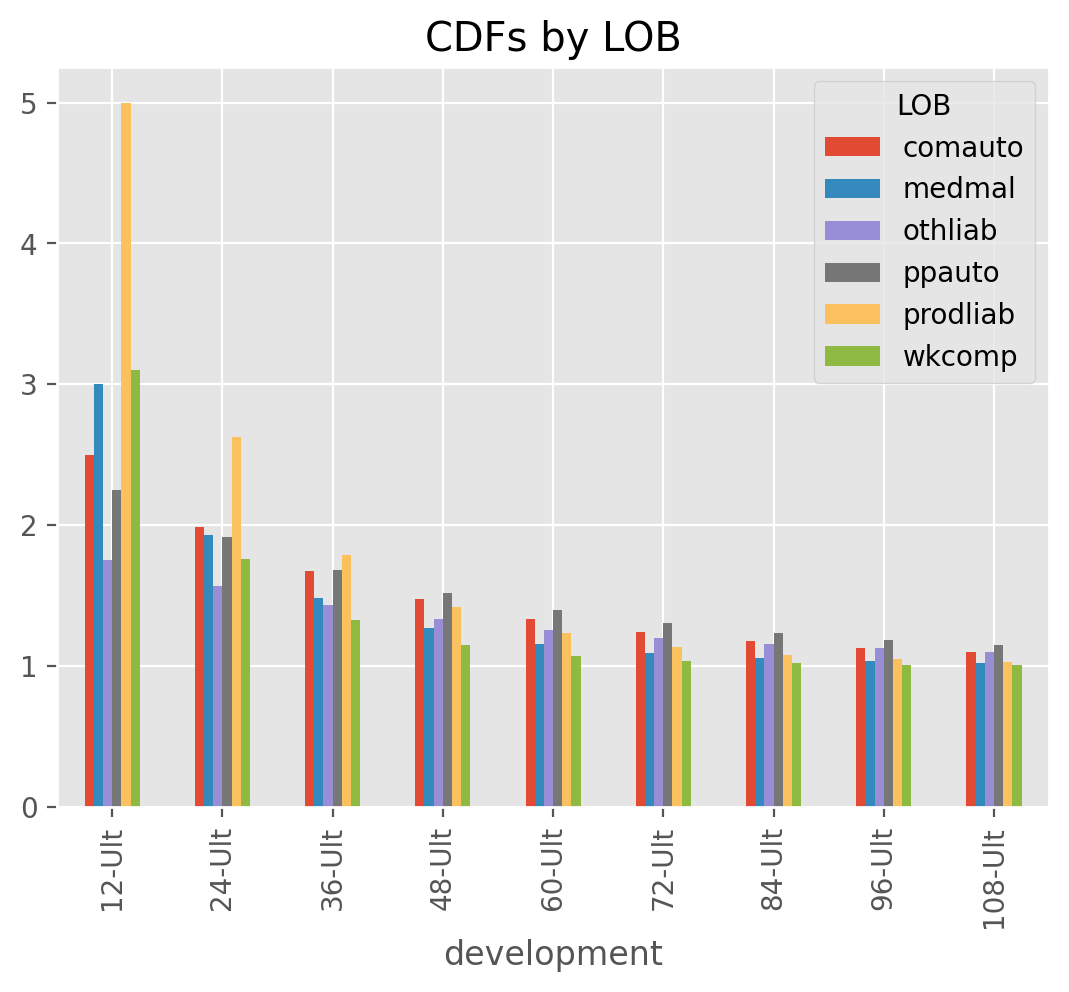

In [14]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

ax = custom_patterns.cdf_.T.plot(kind='bar', title='CDFs by LOB')

In [15]:
CL_model = cl.Chainladder().fit(X=custom_patterns)
#The 'UltExpectedDIRLoss' column in the triangle is EP * ELR, so setting the apriori = 1.000
BF_model = cl.BornhuetterFerguson(apriori=1.0).fit(X=custom_patterns, sample_weight=tri['UltExpectedDIRLoss'].latest_diagonal)
CC_model = cl.CapeCod(trend=0.05, decay=0.95).fit(X=custom_patterns, sample_weight=tri['EarnedPremDIR'].latest_diagonal)

In [16]:
CL_model.ultimate_.to_frame().transpose().style.format('{:,.0f}')

LOB,comauto,medmal,othliab,ppauto,prodliab,wkcomp
origin,,,,,,
1988,"626,097","217,239","317,889","8,690,036","110,973","1,241,715"
1989,"739,235","226,854","385,205","11,255,460","115,700","1,314,504"
1990,"811,859","243,078","406,068","12,717,244","126,842","1,407,060"
1991,"837,836","290,434","493,411","13,251,356","108,096","1,439,986"
1992,"908,594","290,819","467,590","15,072,269","86,199","1,376,625"
1993,"1,018,328","318,502","547,058","17,075,890","116,371","1,274,595"
1994,"1,130,567","320,060","535,705","19,085,496","157,519","1,284,198"
1995,"1,130,451","310,722","421,098","19,840,243","110,700","1,276,595"
1996,"1,014,352","207,767","299,261","18,941,697","73,824","1,295,931"


In [17]:
BF_model.ultimate_.to_frame().transpose().style.format('{:,.0f}')

LOB,comauto,medmal,othliab,ppauto,prodliab,wkcomp
origin,,,,,,
1988,"626,097","217,239","317,889","8,690,036","110,973","1,241,715"
1989,"741,424","227,932","395,061","10,489,736","117,302","1,313,458"
1990,"814,046","244,078","419,288","11,648,428","128,818","1,404,895"
1991,"844,723","288,995","502,324","11,956,498","112,715","1,437,410"
1992,"910,262","287,939","486,776","13,214,472","95,488","1,375,616"
1993,"1,000,256","310,866","565,509","14,425,306","126,166","1,290,811"
1994,"1,098,775","312,129","578,486","15,429,166","167,506","1,321,924"
1995,"1,096,179","313,121","531,044","15,381,933","151,682","1,352,454"
1996,"1,027,631","266,376","489,509","14,290,804","153,084","1,373,468"


In [18]:
CC_model.ultimate_.to_frame().transpose().style.format('{:,.0f}')

LOB,comauto,medmal,othliab,ppauto,prodliab,wkcomp
origin,,,,,,
1988,"626,097","217,239","317,889","8,690,036","110,973","1,241,715"
1989,"731,715","227,036","377,151","11,021,741","115,297","1,313,014"
1990,"804,051","242,992","397,342","12,460,840","125,781","1,404,322"
1991,"836,326","287,864","475,548","13,159,720","108,034","1,436,951"
1992,"906,701","287,029","454,911","14,967,694","88,688","1,376,342"
1993,"1,006,242","310,836","525,969","16,922,690","115,989","1,296,202"
1994,"1,122,393","314,559","529,040","18,943,314","151,137","1,341,202"
1995,"1,146,382","321,680","469,857","20,170,547","128,234","1,406,783"
1996,"1,115,298","286,461","419,828","20,620,220","124,479","1,495,464"


In [19]:
CC_model.detrended_apriori_.to_frame().transpose().style.format('{:.2%}')

LOB,comauto,medmal,othliab,ppauto,prodliab,wkcomp
origin,,,,,,
1988,52.99%,47.38%,38.14%,77.17%,36.05%,47.70%
1989,55.58%,49.72%,39.96%,80.95%,37.77%,49.86%
1990,58.21%,52.21%,41.73%,84.74%,39.50%,51.91%
1991,60.89%,54.81%,43.47%,88.56%,41.16%,53.89%
1992,63.71%,57.39%,45.11%,92.55%,42.90%,55.85%
1993,66.63%,59.95%,46.70%,96.66%,44.81%,57.87%
1994,69.64%,62.44%,48.20%,100.90%,46.79%,60.12%
1995,72.75%,64.94%,49.68%,105.28%,48.74%,62.65%
1996,76.01%,67.58%,51.35%,109.88%,50.89%,65.53%


In [20]:
df_CL_model = CL_model.ultimate_.to_frame().transpose().unstack().reset_index()
df_CL_model.rename(columns={0: 'CL_Ult'}, inplace=True)

df_BF_model = BF_model.ultimate_.to_frame().transpose().unstack().reset_index()
df_BF_model.rename(columns={0: 'BF_Ult'}, inplace=True)

df_CC_model = CC_model.ultimate_.to_frame().transpose().unstack().reset_index()
df_CC_model.rename(columns={0: 'CC_Ult'}, inplace=True)

df_ult = df_CL_model.merge(df_BF_model, on=['LOB', 'origin'], how='outer').merge(df_CC_model, on=['LOB', 'origin'], how='outer')

In [21]:
df_ult.loc[:, 'Selected_Ult'] = df_ult['BF_Ult']
df_ult

,LOB,origin,CL_Ult,BF_Ult,CC_Ult,Selected_Ult
0,comauto,1988,6.260970e+05,6.260970e+05,6.260970e+05,6.260970e+05
1,comauto,1989,7.392345e+05,7.414239e+05,7.317154e+05,7.414239e+05
2,comauto,1990,8.118593e+05,8.140462e+05,8.040508e+05,8.140462e+05
3,comauto,1991,8.378364e+05,8.447233e+05,8.363258e+05,8.447233e+05
4,comauto,1992,9.085936e+05,9.102624e+05,9.067014e+05,9.102624e+05
5,comauto,1993,1.018328e+06,1.000256e+06,1.006242e+06,1.000256e+06
6,comauto,1994,1.130567e+06,1.098775e+06,1.122393e+06,1.098775e+06
7,comauto,1995,1.130451e+06,1.096179e+06,1.146382e+06,1.096179e+06
8,comauto,1996,1.014352e+06,1.027631e+06,1.115298e+06,1.027631e+06
9,comauto,1997,6.808550e+05,9.041841e+05,1.045256e+06,9.041841e+05


## Least Squares Method..............

In [22]:
df_data['origin'] = df_data['origin'].dt.year
df_ult['origin'] = df_ult['origin'].dt.year

In [23]:
df_data = pd.merge(df_data, df_ult[['LOB', 'origin', 'Selected_Ult']], on=['LOB', 'origin'], how='left')

In [24]:
current_eval = '1997-12-31'
prediction_data = df_data[df_data['valuation'] == current_eval]
fitting_data = df_data[df_data['valuation'] != current_eval]

In [25]:
models = {}
predictions = []

for (lob, development), group in fitting_data.groupby(['LOB', 'development']):
    if group.shape[0] > 1:
        X = group[['CumPaidLoss']]
        y = group['Selected_Ult']

        #fit a linear regression model
        model = LinearRegression()
        model.fit(X, y)

        #Store the model for reference
        models[(lob, development)] = model

        target_subset = prediction_data[(prediction_data['LOB'] == lob) & (prediction_data['development'] == development)].copy()
        if not target_subset.empty:
            X_new = target_subset[['CumPaidLoss']]
            target_subset['Least_Squares_Ult'] = model.predict(X_new)
            predictions.append(target_subset)

predictions_df = pd.concat(predictions, ignore_index=True)


In [26]:
Least_squares_df = predictions_df[['LOB', 'origin', 'Least_Squares_Ult']]
df_ult = df_ult.merge(Least_squares_df, on=['LOB', 'origin'], how='left')

In [27]:
df_ult.to_clipboard()

## View of the triangles

In [28]:
from IPython.display import display, HTML
def formatted_tri(lob):
    display(HTML(f"<h3>{lob} CumPaidLoss Triangle</h3>"))
    display(tri.loc[lob, 'CumPaidLoss'])
    display(HTML(f"<h3>{lob} Link Ratios</h3>"))
    display(tri.loc[lob, 'CumPaidLoss'].link_ratio)

In [29]:
for i in list(df_ult['LOB'].unique()):
    formatted_tri(i)

,12,24,36,48,60,72,84,96,108,120
1988,"154,058","326,916","447,963","528,167","574,471","599,428","613,573","619,616","621,956","626,097"
1989,"173,856","357,652","488,306","569,371","624,655","648,988","662,268","668,959","674,441",
1990,"181,888","391,331","527,129","616,793","667,426","698,277","712,917","718,396",,
1991,"179,520","381,993","522,324","613,352","672,472","698,335","711,762",,,
1992,"181,066","403,957","548,391","648,274","706,559","731,033",,,,
1993,"215,436","440,324","596,185","707,671","762,039",,,,,
1994,"249,231","490,657","662,138","768,095",,,,,,
1995,"258,839","511,937","675,166",,,,,,,
1996,"271,565","510,191",,,,,,,,
1997,"272,342",,,,,,,,,


,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,2.1220,1.3703,1.1790,1.0877,1.0434,1.0236,1.0098,1.0038,1.0067
1989,2.0572,1.3653,1.1660,1.0971,1.0390,1.0205,1.0101,1.0082,
1990,2.1515,1.3470,1.1701,1.0821,1.0462,1.0210,1.0077,,
1991,2.1279,1.3674,1.1743,1.0964,1.0385,1.0192,,,
1992,2.2310,1.3575,1.1821,1.0899,1.0346,,,,
1993,2.0439,1.3540,1.1870,1.0768,,,,,
1994,1.9687,1.3495,1.1600,,,,,,
1995,1.9778,1.3188,,,,,,,
1996,1.8787,,,,,,,,


,12,24,36,48,60,72,84,96,108,120
1988,"5,934","47,258","95,054","131,616","165,117","181,937","198,395","206,068","213,374","217,239"
1989,"9,433","51,855","98,976","149,169","175,588","197,590","211,242","217,986","222,707",
1990,"11,996","54,742","118,964","163,695","190,391","213,972","225,199","235,717",,
1991,"9,517","73,420","146,347","199,262","244,987","260,333","275,923",,,
1992,"12,479","78,212","157,400","209,959","244,018","267,007",,,,
1993,"18,229","90,710","166,325","227,891","276,235",,,,,
1994,"14,952","94,303","186,577","252,449",,,,,,
1995,"17,995","110,181","209,222",,,,,,,
1996,"20,390","107,474",,,,,,,,
1997,"20,361",,,,,,,,,


,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,7.9639,2.0114,1.3846,1.2545,1.1019,1.0905,1.0387,1.0355,1.0181
1989,5.4972,1.9087,1.5071,1.1771,1.1253,1.0691,1.0319,1.0217,
1990,4.5634,2.1732,1.3760,1.1631,1.1239,1.0525,1.0467,,
1991,7.7146,1.9933,1.3616,1.2295,1.0626,1.0599,,,
1992,6.2675,2.0125,1.3339,1.1622,1.0942,,,,
1993,4.9761,1.8336,1.3702,1.2121,,,,,
1994,6.3070,1.9785,1.3531,,,,,,
1995,6.1229,1.8989,,,,,,,
1996,5.2709,,,,,,,,


,12,24,36,48,60,72,84,96,108,120
1988,"31,447","87,470","146,807","220,502","256,564","282,111","300,903","308,636","314,566","317,889"
1989,"36,601","99,778","178,262","238,864","289,540","318,666","331,488","343,442","350,684",
1990,"41,035","108,655","190,403","262,674","302,957","334,770","352,726","361,103",,
1991,"39,031","126,807","227,783","316,632","368,941","402,043","426,085",,,
1992,"42,801","126,926","222,655","304,301","350,992","389,250",,,,
1993,"44,930","173,066","293,039","378,512","434,995",,,,,
1994,"54,253","169,202","296,394","402,244",,,,,,
1995,"39,780","167,908","294,332",,,,,,,
1996,"62,630","191,258",,,,,,,,
1997,"54,130",,,,,,,,,


,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,2.7815,1.6784,1.5020,1.1635,1.0996,1.0666,1.0257,1.0192,1.0106
1989,2.7261,1.7866,1.3400,1.2122,1.1006,1.0402,1.0361,1.0211,
1990,2.6479,1.7524,1.3796,1.1534,1.1050,1.0536,1.0237,,
1991,3.2489,1.7963,1.3901,1.1652,1.0897,1.0598,,,
1992,2.9655,1.7542,1.3667,1.1534,1.1090,,,,
1993,3.8519,1.6932,1.2917,1.1492,,,,,
1994,3.1188,1.7517,1.3571,,,,,,
1995,4.2209,1.7529,,,,,,,
1996,3.0538,,,,,,,,


,12,24,36,48,60,72,84,96,108,120
1988,"3,092,818","5,942,711","7,239,089","7,930,109","8,318,795","8,518,201","8,610,355","8,655,509","8,682,451","8,690,036"
1989,"3,556,683","6,753,435","8,219,551","9,018,288","9,441,842","9,647,917","9,753,014","9,800,477","9,823,747",
1990,"4,015,052","7,478,257","9,094,949","9,945,288","10,371,175","10,575,467","10,671,988","10,728,411",,
1991,"4,065,571","7,564,284","9,161,104","10,006,407","10,419,901","10,612,083","10,713,621",,,
1992,"4,551,591","8,344,021","10,047,179","10,901,995","11,336,777","11,555,121",,,,
1993,"5,020,277","9,125,734","10,890,282","11,782,219","12,249,826",,,,,
1994,"5,569,355","9,871,002","11,641,397","12,600,432",,,,,,
1995,"5,803,124","10,008,734","11,807,279",,,,,,,
1996,"5,835,368","9,900,842",,,,,,,,
1997,"5,754,249",,,,,,,,,


,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,1.9215,1.2181,1.0955,1.0490,1.0240,1.0108,1.0052,1.0031,1.0009
1989,1.8988,1.2171,1.0972,1.0470,1.0218,1.0109,1.0049,1.0024,
1990,1.8626,1.2162,1.0935,1.0428,1.0197,1.0091,1.0053,,
1991,1.8606,1.2111,1.0923,1.0413,1.0184,1.0096,,,
1992,1.8332,1.2041,1.0851,1.0399,1.0193,,,,
1993,1.8178,1.1934,1.0819,1.0397,,,,,
1994,1.7724,1.1794,1.0824,,,,,,
1995,1.7247,1.1797,,,,,,,
1996,1.6967,,,,,,,,


,12,24,36,48,60,72,84,96,108,120
1988,"7,719","17,079","32,138","55,930","75,400","99,711","101,039","104,617","110,040","110,973"
1989,"6,387","17,842","35,429","57,222","80,791","95,150","103,731","112,450","112,614",
1990,"8,347","18,022","36,758","71,537","87,621","100,813","121,789","121,255",,
1991,"7,700","21,502","43,272","64,383","78,572","93,042","100,276",,,
1992,"8,223","23,181","37,376","52,041","72,611","76,059",,,,
1993,"12,122","26,156","48,834","82,909","94,462",,,,,
1994,"7,596","19,404","65,507","111,264",,,,,,
1995,"10,264","44,816","62,018",,,,,,,
1996,"20,162","28,107",,,,,,,,
1997,"10,682",,,,,,,,,


,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,2.2126,1.8817,1.7403,1.3481,1.3224,1.0133,1.0354,1.0518,1.0085
1989,2.7935,1.9857,1.6151,1.4119,1.1777,1.0902,1.0841,1.0015,
1990,2.1591,2.0396,1.9462,1.2248,1.1506,1.2081,0.9956,,
1991,2.7925,2.0125,1.4879,1.2204,1.1842,1.0777,,,
1992,2.8190,1.6124,1.3924,1.3953,1.0475,,,,
1993,2.1577,1.8670,1.6978,1.1393,,,,,
1994,2.5545,3.3760,1.6985,,,,,,
1995,4.3663,1.3838,,,,,,,
1996,1.3941,,,,,,,,


,12,24,36,48,60,72,84,96,108,120
1988,"285,804","638,532","865,100","996,363","1,084,351","1,133,188","1,169,749","1,196,917","1,229,203","1,241,715"
1989,"307,720","684,140","916,996","1,065,674","1,154,072","1,210,479","1,249,886","1,291,512","1,308,706",
1990,"320,124","757,479","1,017,144","1,169,014","1,258,975","1,315,368","1,368,374","1,394,675",,
1991,"347,417","793,749","1,053,414","1,209,556","1,307,164","1,381,645","1,414,747",,,
1992,"342,982","781,402","1,014,982","1,172,915","1,281,864","1,328,801",,,,
1993,"342,385","743,433","959,147","1,113,314","1,187,581",,,,,
1994,"351,060","750,392","993,751","1,114,842",,,,,,
1995,"343,841","768,575","962,081",,,,,,,
1996,"381,484","736,040",,,,,,,,
1997,"340,132",,,,,,,,,


,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,2.2342,1.3548,1.1517,1.0883,1.0450,1.0323,1.0232,1.0270,1.0102
1989,2.2233,1.3404,1.1621,1.0830,1.0489,1.0326,1.0333,1.0133,
1990,2.3662,1.3428,1.1493,1.0770,1.0448,1.0403,1.0192,,
1991,2.2847,1.3271,1.1482,1.0807,1.0570,1.0240,,,
1992,2.2783,1.2989,1.1556,1.0929,1.0366,,,,
1993,2.1713,1.2902,1.1607,1.0667,,,,,
1994,2.1375,1.3243,1.1219,,,,,,
1995,2.2353,1.2518,,,,,,,
1996,1.9294,,,,,,,,


In [35]:
tri.loc['wkcomp', 'CumPaidLoss'].link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,2.2342,1.3548,1.1517,1.0883,1.0450,1.0323,1.0232,1.0270,1.0102
1989,2.2233,1.3404,1.1621,1.0830,1.0489,1.0326,1.0333,1.0133,
1990,2.3662,1.3428,1.1493,1.0770,1.0448,1.0403,1.0192,,
1991,2.2847,1.3271,1.1482,1.0807,1.0570,1.0240,,,
1992,2.2783,1.2989,1.1556,1.0929,1.0366,,,,
1993,2.1713,1.2902,1.1607,1.0667,,,,,
1994,2.1375,1.3243,1.1219,,,,,,
1995,2.2353,1.2518,,,,,,,
1996,1.9294,,,,,,,,
